# Your Title Here

**Name(s)**: Vishwak Pabba and Manav Jairam

**Website Link**: (your website link)

## Code

In [2]:
import pandas as pd
import numpy as np
import os

import plotly.express as px
pd.options.plotting.backend = 'plotly'

### Framing the Problem

In [3]:
lol = pd.read_csv(os.path.join('data', '2022_LoL_esports_match_data_from_OraclesElixir.csv'), low_memory = False)
lol.head()

,gameid,datacompleteness,url,league,year,split,playoffs,date,game,patch,...,opp_csat15,golddiffat15,xpdiffat15,csdiffat15,killsat15,assistsat15,deathsat15,opp_killsat15,opp_assistsat15,opp_deathsat15
0,ESPORTSTMNT01_2690210,complete,NaN,LCK CL,2022,Spring,0,2022-01-10 07:44:08,1,12.01,...,121.0,391.0,345.0,14.0,0.0,1.0,0.0,0.0,1.0,0.0
1,ESPORTSTMNT01_2690210,complete,NaN,LCK CL,2022,Spring,0,2022-01-10 07:44:08,1,12.01,...,100.0,541.0,-275.0,-11.0,2.0,3.0,2.0,0.0,5.0,1.0
2,ESPORTSTMNT01_2690210,complete,NaN,LCK CL,2022,Spring,0,2022-01-10 07:44:08,1,12.01,...,119.0,-475.0,153.0,1.0,0.0,3.0,0.0,3.0,3.0,2.0
3,ESPORTSTMNT01_2690210,complete,NaN,LCK CL,2022,Spring,0,2022-01-10 07:44:08,1,12.01,...,149.0,-793.0,-1343.0,-34.0,2.0,1.0,2.0,3.0,3.0,0.0
4,ESPORTSTMNT01_2690210,complete,NaN,LCK CL,2022,Spring,0,2022-01-10 07:44:08,1,12.01,...,21.0,443.0,-497.0,7.0,1.0,2.0,2.0,0.0,6.0,2.0


In [4]:
#cleaning
lol.isnull().sum() #Get the number of NaN values in each column

gameid                   0
datacompleteness         0
url                 126984
league                   0
year                     0
                     ...  
assistsat15          21828
deathsat15           21828
opp_killsat15        21828
opp_assistsat15      21828
opp_deathsat15       21828
Length: 123, dtype: int64

In [5]:
def quantitative_distribution(col):
    bins = np.histogram(col.dropna(), bins=10) #make the bins
    probs = bins[0] / len(col.dropna()) #get probability for each bin

    imputed_vals = np.array([])

    for i in range(col.isnull().sum()):
        bin_idx = np.random.choice(len(bins[0]), p=probs) #randomly choose the bin
        val = np.random.uniform(bins[1][bin_idx], bins[1][bin_idx + 1]) #randomly choose a value in the range of the bin
        imputed_vals = np.append(imputed_vals, val)

    return imputed_vals

lol.loc[lol['minionkills'].isna(), 'minionkills'] = quantitative_distribution(lol['minionkills']) #applying the function

minionkills_sum = lol.groupby(['gameid', 'side'])[['minionkills', 'assists']].sum().reset_index() #groupby to get the totals
minionkills_sum = minionkills_sum.rename(columns={'minionkills':'teamminionkills', 'assists':'teamassists'})
minionkills_sum

lol = lol.merge(minionkills_sum, how='left') #use a left merge of the dataframes to match each team total with game and team

def calc_prop(row, col_name, team_col):
    if(row[team_col] == 0): #if the total is 0, we return 0 to avoid NaN and inf values
        return 0
    else:
        return row[col_name] / row[team_col]

#we use lambda function to create arrays the hold the proportions for each row for the game statistics
prop_kills = lol.apply(lambda row: calc_prop(row, 'kills', 'teamkills'), axis=1)
prop_assists = lol.apply(lambda row: calc_prop(row, 'assists', 'teamassists'), axis=1)
prop_deaths = lol.apply(lambda row: calc_prop(row, 'deaths', 'teamdeaths'), axis=1)
prop_minions = lol.apply(lambda row: calc_prop(row, 'minionkills', 'teamminionkills'), axis=1)

#we assign these array values to new columns
lol = lol.assign(prop_kills=prop_kills.values, prop_assists=prop_assists.values, prop_deaths=prop_deaths.values, prop_minions=prop_minions.values)
lol.head()

,gameid,datacompleteness,url,league,year,split,playoffs,date,game,patch,...,deathsat15,opp_killsat15,opp_assistsat15,opp_deathsat15,teamminionkills,teamassists,prop_kills,prop_assists,prop_deaths,prop_minions
0,ESPORTSTMNT01_2690210,complete,NaN,LCK CL,2022,Spring,0,2022-01-10 07:44:08,1,12.01,...,0.0,0.0,1.0,0.0,1360.0,38,0.222222,0.052632,0.157895,0.161765
1,ESPORTSTMNT01_2690210,complete,NaN,LCK CL,2022,Spring,0,2022-01-10 07:44:08,1,12.01,...,2.0,0.0,5.0,1.0,1360.0,38,0.222222,0.157895,0.263158,0.024265
2,ESPORTSTMNT01_2690210,complete,NaN,LCK CL,2022,Spring,0,2022-01-10 07:44:08,1,12.01,...,0.0,3.0,3.0,2.0,1360.0,38,0.222222,0.078947,0.105263,0.130147
3,ESPORTSTMNT01_2690210,complete,NaN,LCK CL,2022,Spring,0,2022-01-10 07:44:08,1,12.01,...,2.0,3.0,3.0,0.0,1360.0,38,0.222222,0.052632,0.210526,0.152941
4,ESPORTSTMNT01_2690210,complete,NaN,LCK CL,2022,Spring,0,2022-01-10 07:44:08,1,12.01,...,2.0,0.0,6.0,2.0,1360.0,38,0.111111,0.157895,0.263158,0.030882


### Baseline Model

In [6]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
#from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.utils import shuffle

from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score

df = lol[lol['position']=='team']

def baseline_model(df):
    X = df[["kills", "deaths"]]
    y = df["result"]

    pl = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression())
    ])

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    shuffle_split = ShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

    for train_index, test_index in shuffle_split.split(X):
            # Split the data into training and testing sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
    # Fit the pipeline on the training data
    pl.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = pl.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Calculate precision
    precision = precision_score(y_test, y_pred)
    print("Precision:", precision)

    # Calculate recall
    recall = recall_score(y_test, y_pred)
    print("Recall:", recall)

baseline_model(df)

Accuracy: 0.957429718875502
Precision: 0.953882538431218
Recall: 0.9622266401590457


### Final Model

In [89]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Binarizer

from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score

df = shuffle(df, random_state=42)

stats = df.columns[40:69]
columns = [*['side', 'kills', 'deaths'], *stats]

X = df[columns].fillna(0)
y = df['result'].fillna(0)

preproc = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), ["kills", "deaths"]), 
        ('encoding', OneHotEncoder(), ['side']), 
        ('binarizer', Binarizer(), columns[3:])
    ],
    remainder = 'passthrough'
)

pl = Pipeline([
    ('preprocessor', preproc), 
    ('tree', DecisionTreeClassifier())
])

In [114]:
from sklearn.metrics import f1_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

hyperparameters_1 = {
'tree__max_depth': [1,3,5,6], 
'tree__min_samples_split': [10,15,18,23],
'tree__criterion': ['gini', 'entropy'],
'preprocessor__binarizer__threshold': [1,2,3,4]
}

searcher_1 = GridSearchCV(pl, hyperparameters_1, cv=5)
searcher_1.fit(X_train, y_train)

y_pred_1 = searcher_1.predict(X_test)


f1_score = f1_score(y_test, y_pred_1)
print("F1 Score:", f1_score)
print(searcher_1.best_params_)

F1 Score: 0.9713170731707317
{'preprocessor__binarizer__threshold': 4, 'tree__criterion': 'entropy', 'tree__max_depth': 6, 'tree__min_samples_split': 10}


In [115]:
from sklearn.metrics import f1_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

hyperparameters_2 = {
'tree__max_depth': [8, 9, 10, 12], 
'tree__min_samples_split': [20, 25, 30, 35],
'tree__criterion': ['gini', 'entropy'],
'preprocessor__binarizer__threshold': [4,5,6,7]
}

searcher_2 = GridSearchCV(pl, hyperparameters_2, cv=5)
searcher_2.fit(X_train, y_train)

y_pred_2 = searcher_2.predict(X_test)

f1_score = f1_score(y_test, y_pred_2)
print("F1 Score:", f1_score)
print(searcher_2.best_params_)

F1 Score: 0.9825933893995696
{'preprocessor__binarizer__threshold': 6, 'tree__criterion': 'gini', 'tree__max_depth': 9, 'tree__min_samples_split': 25}


In [116]:
from sklearn.metrics import f1_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

hyperparameters_3 = {
'tree__max_depth': [9, 10, 12, 15], 
'tree__min_samples_split': [30, 35, 40, 45],
'tree__criterion': ['gini', 'entropy'],
'preprocessor__binarizer__threshold': [5,6,7,8]
}

searcher_3 = GridSearchCV(pl, hyperparameters_3, cv=5)
searcher_3.fit(X_train, y_train)

y_pred_3 = searcher_3.predict(X_test)

f1_score = f1_score(y_test, y_pred_3)
print("F1 Score:", f1_score)
print(searcher_3.best_params_)

F1 Score: 0.9808518952715904
{'preprocessor__binarizer__threshold': 6, 'tree__criterion': 'entropy', 'tree__max_depth': 10, 'tree__min_samples_split': 40}


### Fairness Analysis

In [176]:
from sklearn import metrics

In [177]:
results = X_test
results['pred'] = y_pred_2
results['actual'] = y_test

results['is_blue'] = (results.side == 'Blue').replace({True: 'blue', False: 'false'})

In [178]:
results.groupby('is_blue')['pred'].mean().to_frame()

,pred
is_blue,
blue,0.543343
false,0.483067


In [179]:
(
    results
    .groupby('is_blue')
    .apply(lambda x: metrics.accuracy_score(x['actual'], x['pred']))
    .rename('F1 Score')
    .to_frame()
)

,F1 Score
is_blue,
blue,0.982165
false,0.982094


In [180]:
obs = results.groupby('is_blue').apply(lambda x: metrics.accuracy_score(x['actual'], x['pred'])).diff().iloc[-1]
obs

-7.087665379534869e-05

In [181]:
diff_in_acc = []
for _ in range(1000):
    s = (
        results[['is_blue', 'pred', 'actual']]
        .assign(is_blue=results.is_blue.sample(frac=1.0, replace=False).reset_index(drop=True))
        .groupby('is_blue')
        .apply(lambda x: metrics.accuracy_score(x['actual'], x['pred']))
        .diff()
        .iloc[-1]
    )
    
    diff_in_acc.append(s)

In [185]:
fig = pd.Series(diff_in_acc).plot(kind='hist', histnorm='probability', nbins=10,
                            title='Difference in Accuracy (Young - Old)')
fig.add_vline(x=obs, line_color='red')
fig.update_layout(xaxis_range=[-1, 1])
fig.add_annotation(text='<span style="color:red">Observed Difference in Accuracy</span>', x=-0.075,showarrow=False, y=0.17)

In [162]:
import matplotlib.pyplot as plt

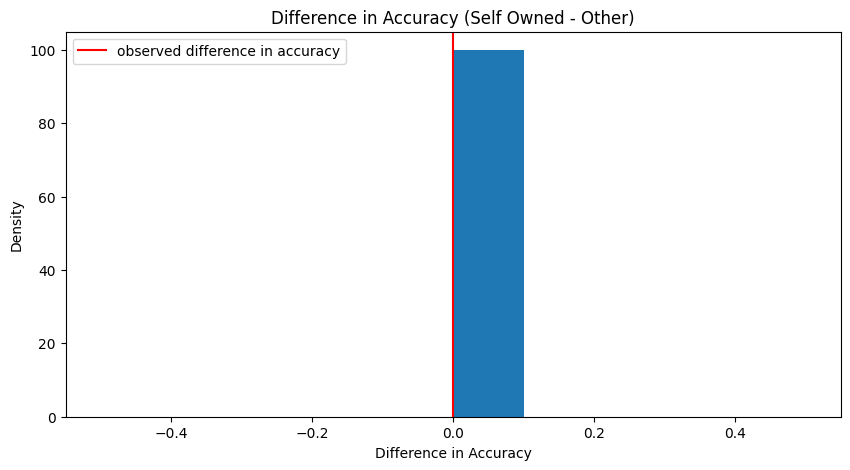

In [182]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(10, 5))
plt.hist(pd.Series(diff_in_acc))
plt.title('Difference in Accuracy (Self Owned - Other)')
plt.xlabel('Difference in Accuracy')
plt.ylabel('Density')

plt.axvline(x=obs, color='red', label='observed difference in accuracy')
plt.legend(loc='upper left')

plt.show()

In [183]:
(np.array(diff_in_acc) >= obs).mean()

1.0